In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import re
from functools import partial
from typing import List

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.notebook import tqdm
from scipy.stats import skew, kurtosis, mode
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import skew, kurtosis
import statsmodels.api as sm

from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, 
    RepeatedKFold, cross_val_score as cvs, cross_val_predict as cvp
)
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve, 
    RocCurveDisplay, cohen_kappa_score, confusion_matrix, log_loss, f1_score, 
    median_absolute_error, mean_squared_error, recall_score, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, 
    PowerTransformer, PolynomialFeatures, RobustScaler
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

sns.set()
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)


# **Import Dataset**

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submision.csv')

train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

In [3]:
train.head()

,origin_host,origin_port,response_host,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size,traffic
0,103.255.15.27,45314,103.255.15.23,42001,0.000090,11125.474801,NaN,22250.949602,1.00,0.0,1.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000e+00,NaN,89.883804,0.000000,1.000000,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,0.0,89.883804,NaN,29200.0,NaN,NaN,Background
1,103.255.15.27,45060,103.255.15.23,42000,0.000033,30174.848921,30174.848921,60349.697842,1.00,NaN,1.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,33.140182,0.000000,NaN,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,33.140182,NaN,29200.0,0.0,NaN,Background
2,103.255.15.23,3440,52.45.16.192,443,61.977190,0.322699,0.242025,0.564724,0.75,2.0,2.0,0.0,NaN,6.0,NaN,0.0,0.0,0.0,0.0,70.8,408.733333,215.628571,3.261959e+06,4.408952e+06,NaN,121.770606,2.857143,NaN,202.285714,875.857143,0.0,0.0,NaN,0.0,NaN,0.0,401089.021138,9.861604e+06,29200.0,NaN,90.0,Background
3,103.255.15.150,56132,8.8.8.8,53,0.024249,NaN,82.478178,164.956355,1.00,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,36.0,NaN,54.750000,1.192093e+01,NaN,8082.946142,9031.360437,NaN,2.0,72.000000,147.000000,0.0,NaN,NaN,0.0,0.0,0.0,24248.838425,NaN,0.0,NaN,0.0,Benign
4,103.255.15.150,43358,8.8.8.8,53,0.027580,NaN,NaN,72.516256,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,36.0,NaN,65.500000,0.000000e+00,0.000000e+00,27580.022812,4749.814781,1.000000,1.0,36.000000,95.000000,0.0,0.0,0.0,0.0,NaN,0.0,27580.022812,0.000000e+00,0.0,NaN,0.0,Benign


In [4]:
train.nunique()

origin_host                       2389
origin_port                      61264
response_host                     7100
response_port                     3540
flow_duration                   120442
forward_packets_per_sec         129380
backward_packets_per_sec        137819
flow_packets_per_sec            135837
down_up_ratio                     5448
flow_FIN_flags                      12
flow_SYN_flags                      15
flow_RST_flags                      38
forward_PSH_flags                  490
backward_PSH_flags                 910
flow_ACK_flags                    1918
forward_URG_flags                    3
backward_URG_flags                   2
flow_CWR_flags                       5
flow_ECE_flags                       3
forward_pkts_payload             19801
backward_pkts_payload            27400
flow_pkts_payload                37029
forward_iat                     122253
backward_iat                    110385
flow_iat                        146216
payload_bytes_per_sec    

In [5]:
train.describe()

,origin_port,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size
count,416473.000000,416473.000000,299409.000000,293081.000000,324234.000000,304723.000000,292858.000000,304424.000000,325463.000000,311037.000000,299948.000000,352919.000000,288942.000000,312173.000000,321925.000000,276814.000000,339171.000000,280192.000000,276811.000000,333132.000000,3.474480e+05,3.062090e+05,3.179020e+05,3.233850e+05,300455.000000,327518.000000,336475.000000,2.974230e+05,289376.000000,2.909360e+05,267275.000000,364192.000000,2.780090e+05,2.946960e+05,3.422090e+05,3.187160e+05,317843.000000,308722.000000,303936.000000
mean,38683.205413,5100.549457,9.661306,1843.291061,1644.112145,3324.893938,0.884547,0.562111,0.912921,0.494089,7.805036,10.857693,34.689834,0.001586,0.000006,0.002370,0.000032,52.609411,311.203244,184.001460,1.195912e+06,3.451998e+05,1.086081e+06,3.444660e+04,13.038672,12.819559,1529.081703,1.597022e+04,20.726439,6.292774e+03,0.028913,2.462795,1.016916e+03,6.010251e+06,7.430817e+05,4.107818e+06,14914.081487,20925.110698,4308.351308
std,18072.735011,12938.833174,105.893481,5082.812608,4516.829821,9299.108522,0.530388,0.825855,1.008394,0.902553,78.326943,125.711515,355.809932,0.039950,0.002493,0.058596,0.006191,52.985930,572.378687,287.359857,7.293417e+06,1.688727e+06,7.210516e+06,2.211850e+05,89.744916,91.756486,17301.107582,1.614213e+05,1004.143776,6.115430e+04,0.564866,16.923030,6.763078e+04,1.917467e+07,1.054241e+07,1.930125e+07,15027.007146,29074.024798,10773.489084
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,28646.000000,53.000000,0.000149,3.655525,3.242029,8.006638,0.846154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,44.000000,0.000000e+00,0.000000e+00,2.889633e+02,4.100035e+00,1.000000,1.000000,36.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.630783e+02,0.000000e+00,0.000000,0.000000,0.000000
50%,42700.000000,443.000000,0.025976,39.527141,43.919854,82.725568,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,95.000000,65.500000,2.098083e+01,3.900528e+02,9.891148e+03,5.389180e+03,2.000000,2.000000,72.000000,1.470000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.586889e+04,0.000000e+00,8192.000000,0.000000,0.000000
75%,53137.000000,443.000000,0.340028,80.680638,80.192417,160.358774,1.000000,1.000000,2.000000,1.000000,3.000000,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000,83.400000,456.888889,257.105263,3.420152e+04,2.246001e+04,2.552104e+04,1.647541e+04,9.000000,7.000000,769.000000,4.112000e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.770810e+05,0.000000e+00,29200.000000,65160.000000,402.000000
max,65535.000000,65522.000000,17393.030600,223696.213333,88768.338624,182361.043478,6.000000,15.000000,23.000000,101.000000,3953.000000,48653.000000,118234.000000,2.000000,1.000000,4.000000,2.000000,3718.933934,19194.344828,10265.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416473 entries, 0 to 416472
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   origin_host                   416473 non-null  object 
 1   origin_port                   416473 non-null  int64  
 2   response_host                 416473 non-null  object 
 3   response_port                 416473 non-null  int64  
 4   flow_duration                 299409 non-null  float64
 5   forward_packets_per_sec       293081 non-null  float64
 6   backward_packets_per_sec      324234 non-null  float64
 7   flow_packets_per_sec          304723 non-null  float64
 8   down_up_ratio                 292858 non-null  float64
 9   flow_FIN_flags                304424 non-null  float64
 10  flow_SYN_flags                325463 non-null  float64
 11  flow_RST_flags                311037 non-null  float64
 12  forward_PSH_flags             299948 non-nul

In [7]:
train.isna().sum()

origin_host                          0
origin_port                          0
response_host                        0
response_port                        0
flow_duration                   117064
forward_packets_per_sec         123392
backward_packets_per_sec         92239
flow_packets_per_sec            111750
down_up_ratio                   123615
flow_FIN_flags                  112049
flow_SYN_flags                   91010
flow_RST_flags                  105436
forward_PSH_flags               116525
backward_PSH_flags               63554
flow_ACK_flags                  127531
forward_URG_flags               104300
backward_URG_flags               94548
flow_CWR_flags                  139659
flow_ECE_flags                   77302
forward_pkts_payload            136281
backward_pkts_payload           139662
flow_pkts_payload                83341
forward_iat                      69025
backward_iat                    110264
flow_iat                         98571
payload_bytes_per_sec    

In [8]:
# Percentage of missing values
train.isna().sum() / train.shape[0] * 100

origin_host                      0.000000
origin_port                      0.000000
response_host                    0.000000
response_port                    0.000000
flow_duration                   28.108425
forward_packets_per_sec         29.627851
backward_packets_per_sec        22.147654
flow_packets_per_sec            26.832472
down_up_ratio                   29.681396
flow_FIN_flags                  26.904265
flow_SYN_flags                  21.852557
flow_RST_flags                  25.316407
forward_PSH_flags               27.979005
backward_PSH_flags              15.260053
flow_ACK_flags                  30.621673
forward_URG_flags               25.043640
backward_URG_flags              22.702072
flow_CWR_flags                  33.533746
flow_ECE_flags                  18.561107
forward_pkts_payload            32.722649
backward_pkts_payload           33.534467
flow_pkts_payload               20.011141
forward_iat                     16.573703
backward_iat                    26

In [9]:
train.shape

(416473, 42)

In [10]:
train['traffic'].value_counts()

traffic
Benign                 260576
Background             127616
Probing                 17543
Bruteforce               4414
Bruteforce-XML           3860
XMRIGCC CryptoMiner      2464
Name: count, dtype: int64

# **Exploratory Data Analysis (EDA)**

In [11]:
LABEL = "traffic"

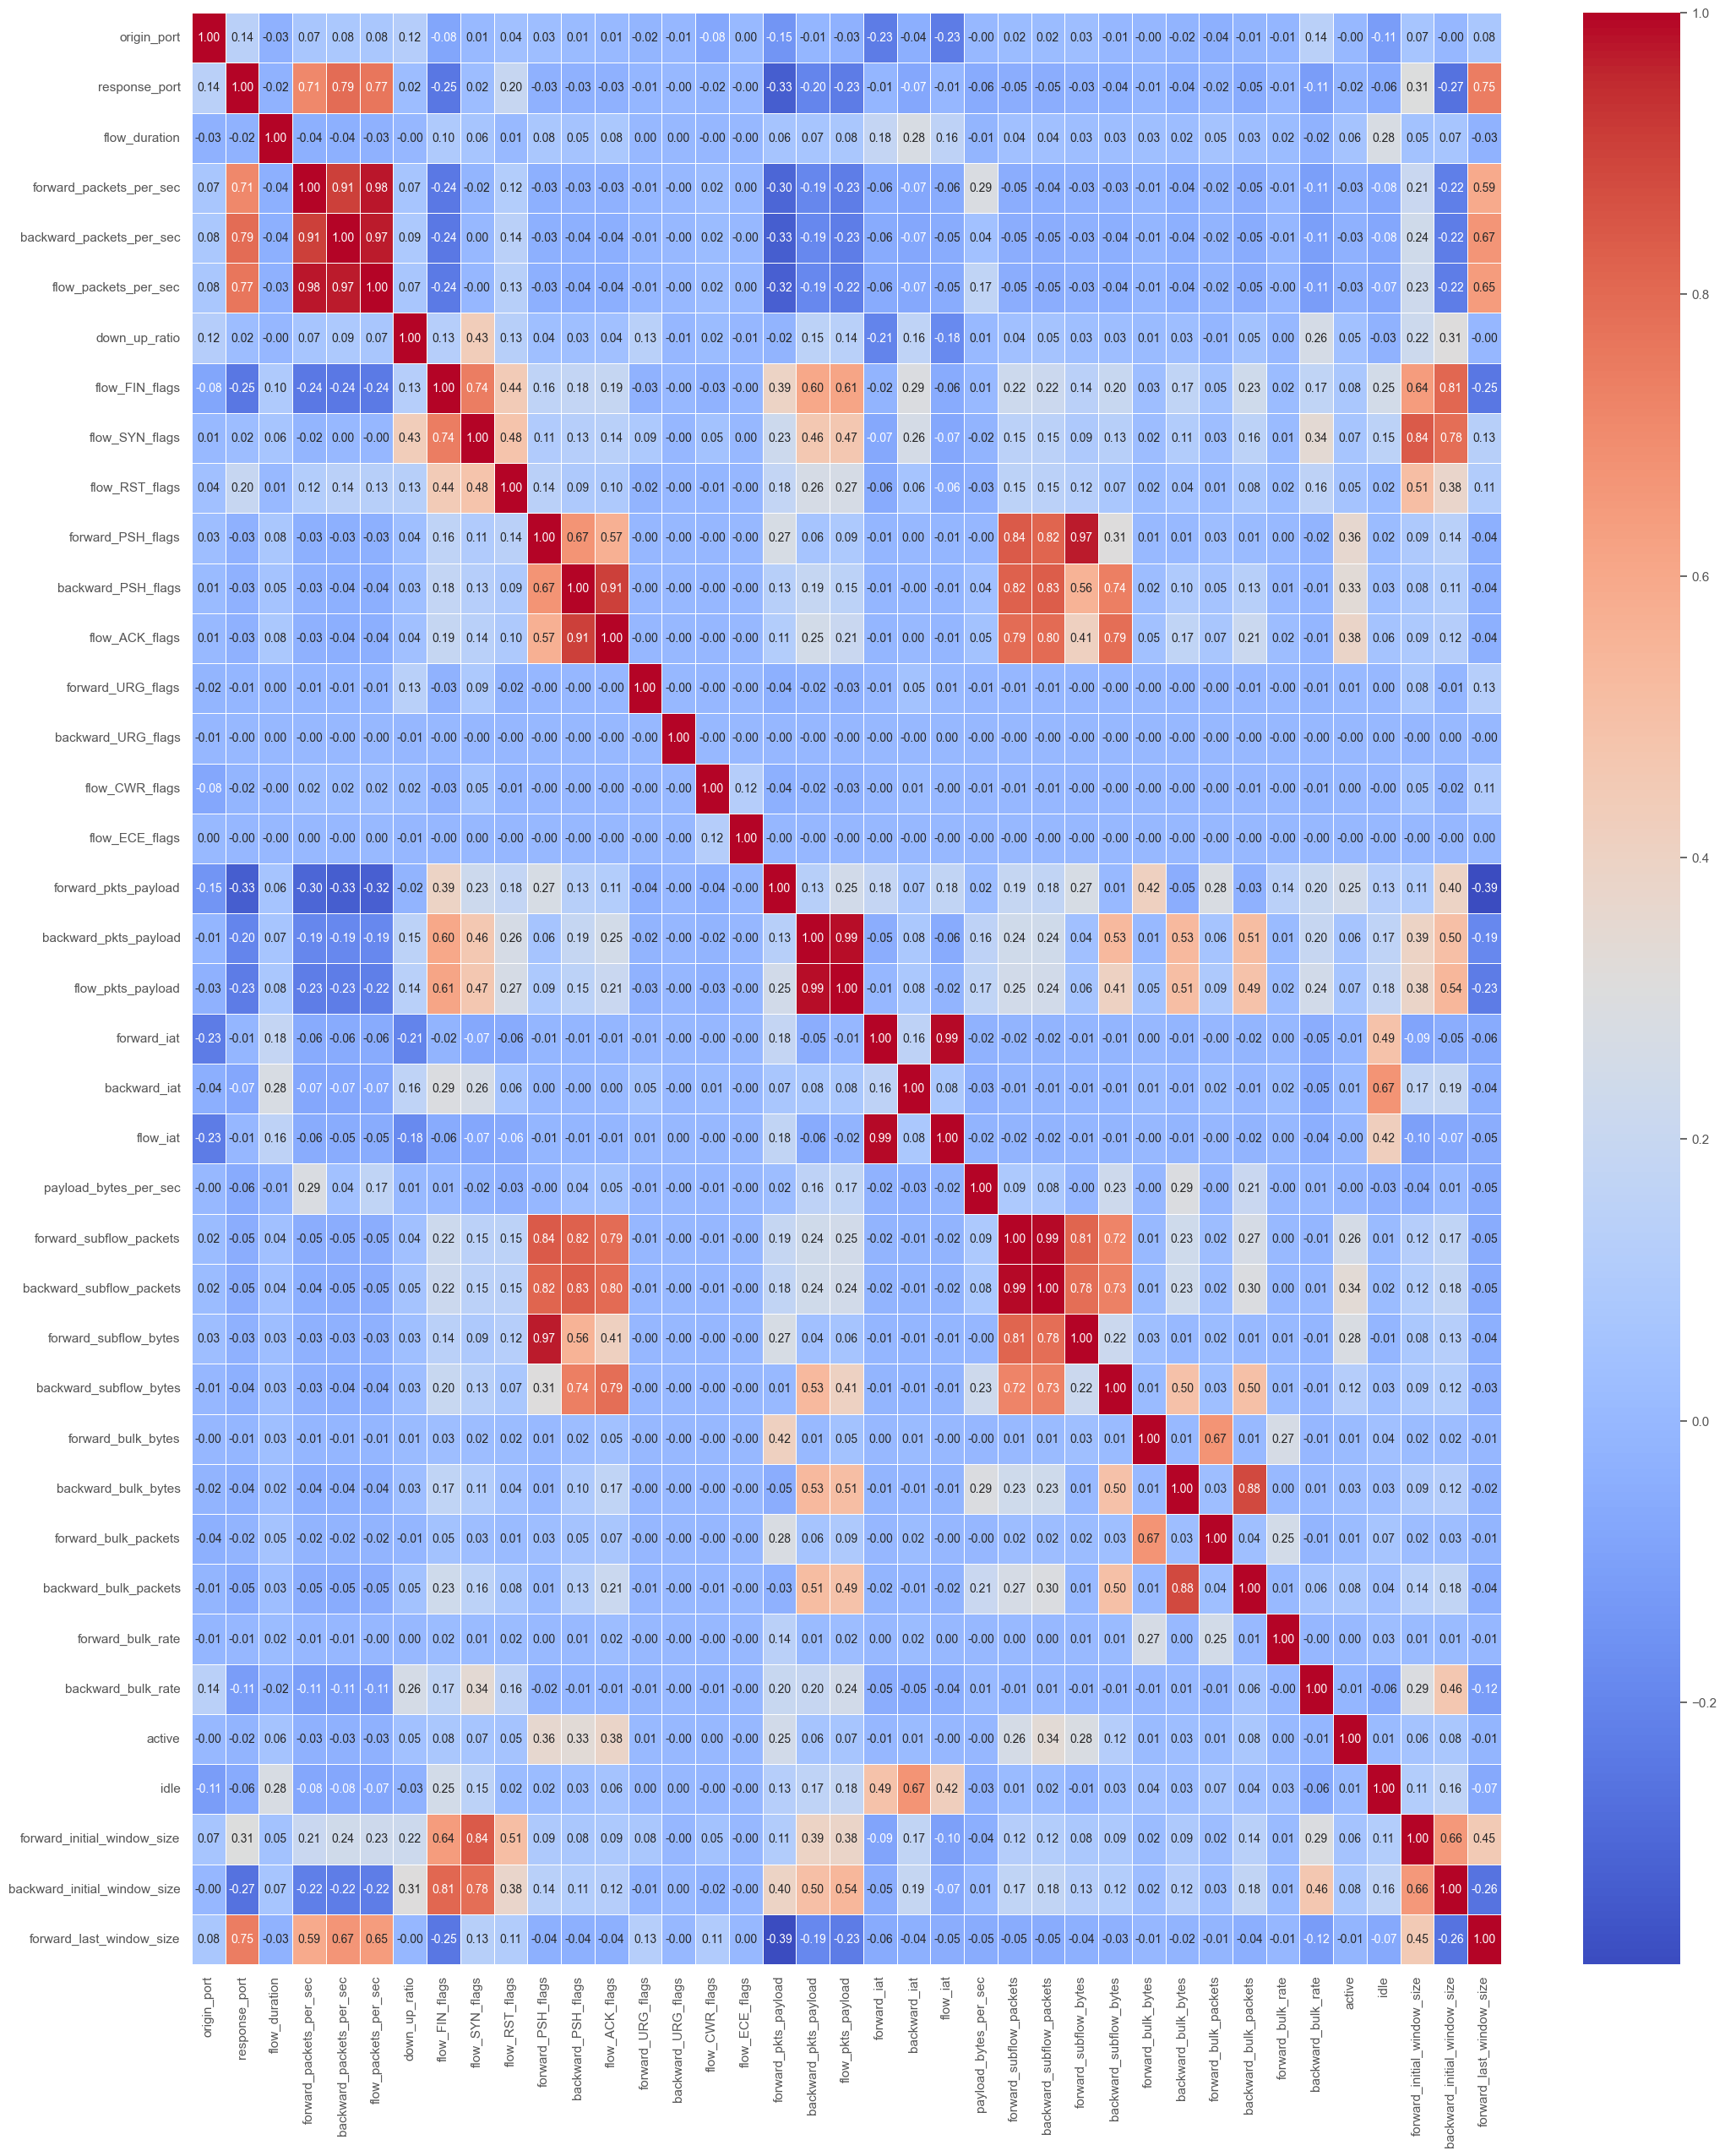

In [12]:
plt.figure(figsize=(25,30))

corr_matrix = train.drop(columns=['response_host', 'origin_host', 'traffic']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.show()

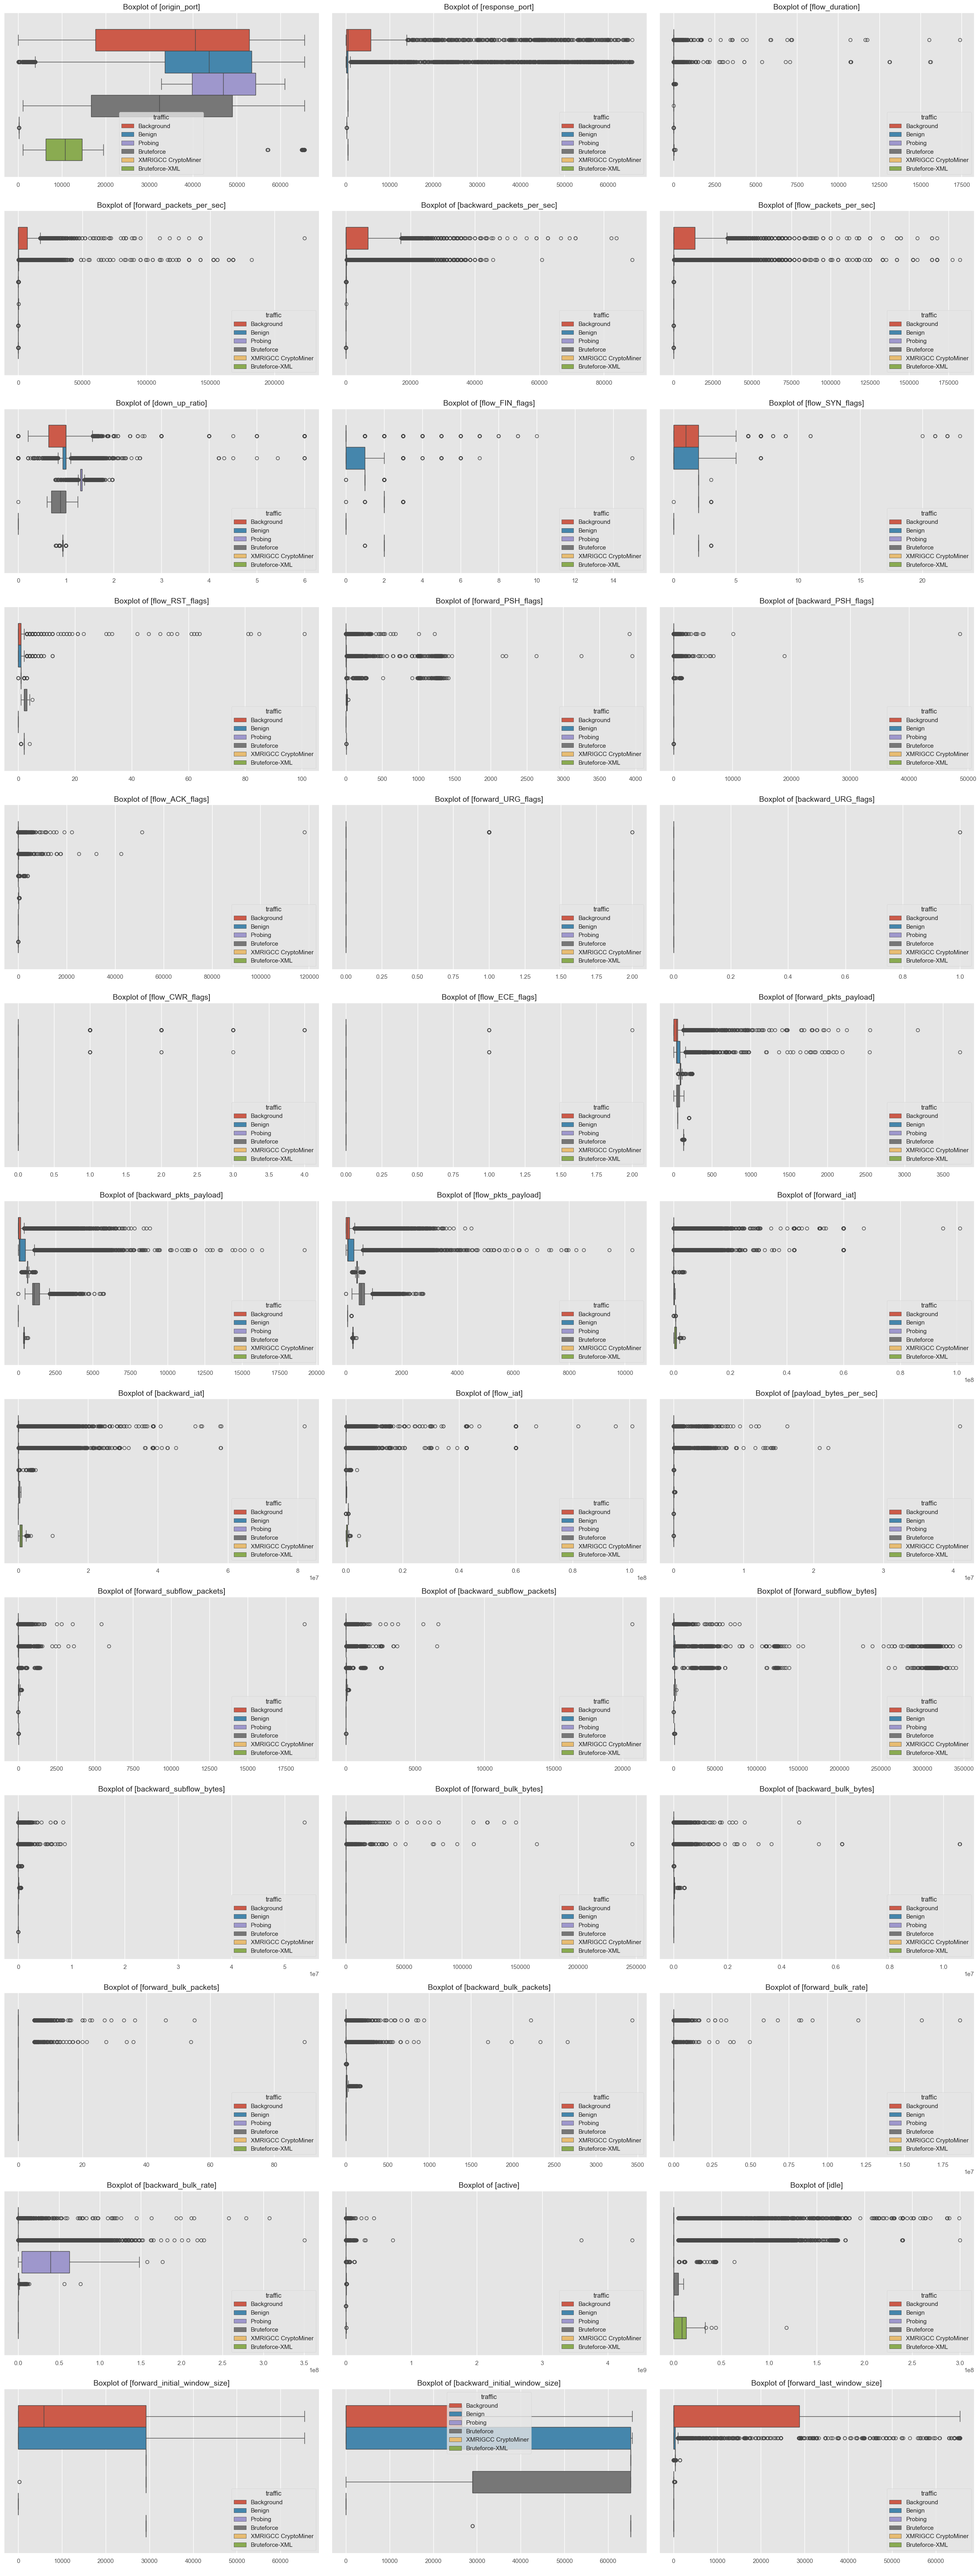

In [13]:
# Define the number of rows and columns
n_cols = 3
n_rows = (len(train.columns) + n_cols - 1) // n_cols  # Ensures we have enough rows

# Set the figure size dynamically based on the number of rows and columns
plt.figure(figsize=(25, 5 * n_rows))

# Plot each column in the train dataset using a boxplot
for j, i in enumerate(train.select_dtypes(exclude='object').columns, 1):
    plt.subplot(n_rows, n_cols, j)
    sns.boxplot(data=train, x=train[i], hue=LABEL)
    plt.title('Boxplot of ['+ i +']', size=14)
    plt.xlabel(" ")

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


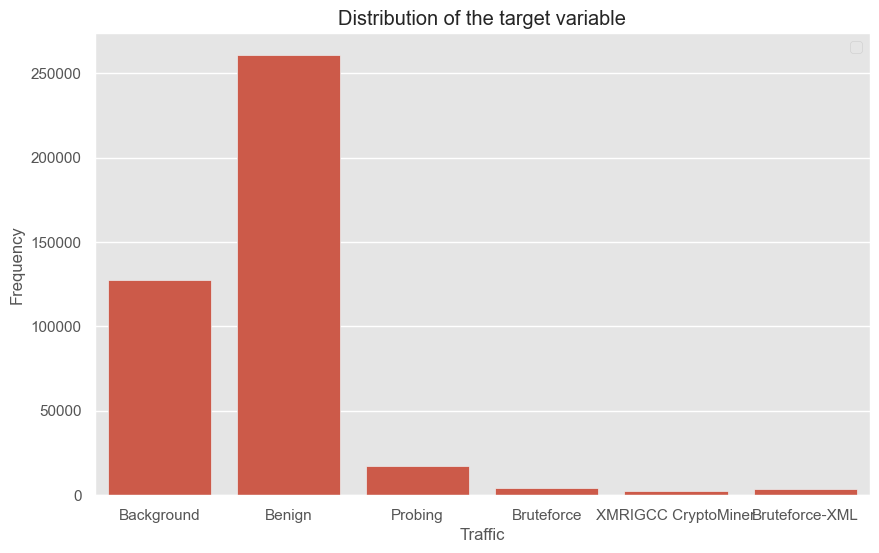

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x=LABEL)
plt.title('Distribution of the target variable')
plt.xlabel('Traffic')
plt.ylabel('Frequency')
plt.legend()
plt.show()

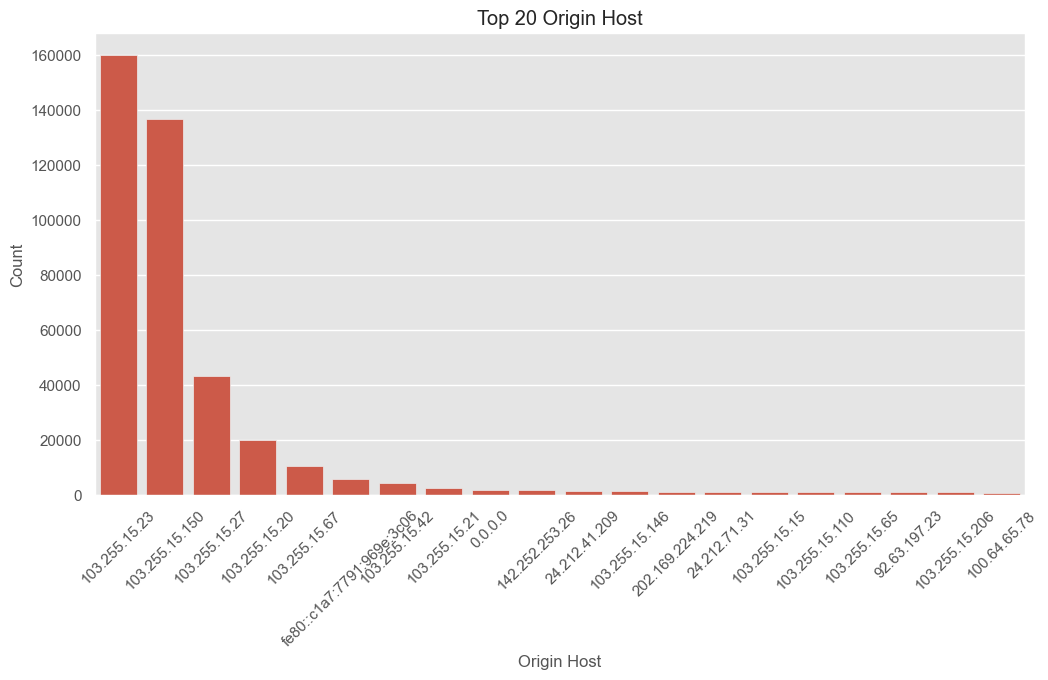

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='origin_host', order=train['origin_host'].value_counts().iloc[:20].index)
plt.title('Top 20 Origin Host')
plt.xlabel('Origin Host')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

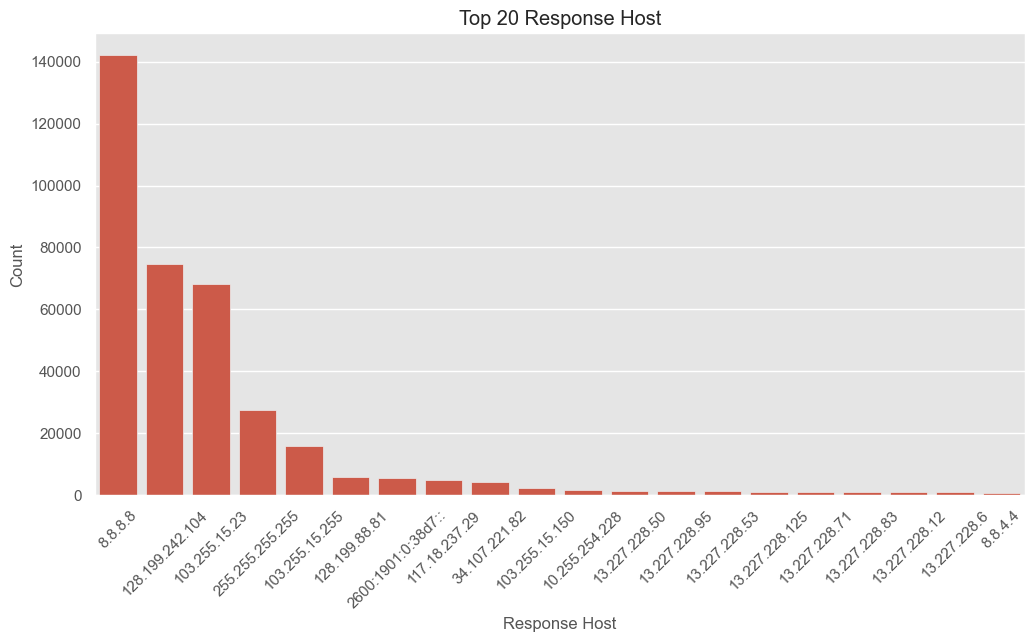

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='response_host', order=train['response_host'].value_counts().iloc[:20].index)
plt.title('Top 20 Response Host')
plt.xlabel('Response Host')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

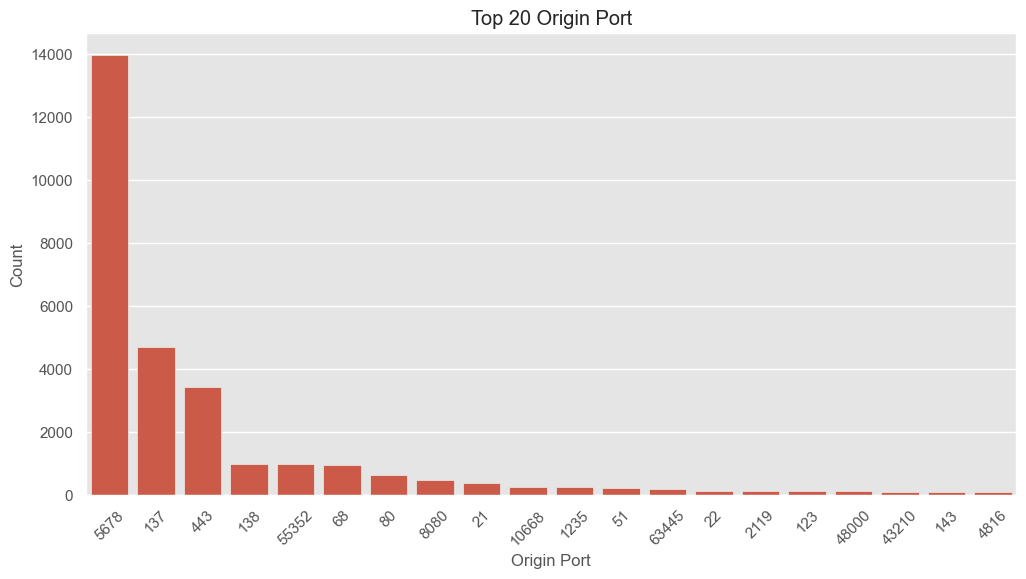

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='origin_port', order=train['origin_port'].value_counts().iloc[:20].index)
plt.title('Top 20 Origin Port')
plt.xlabel('Origin Port')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

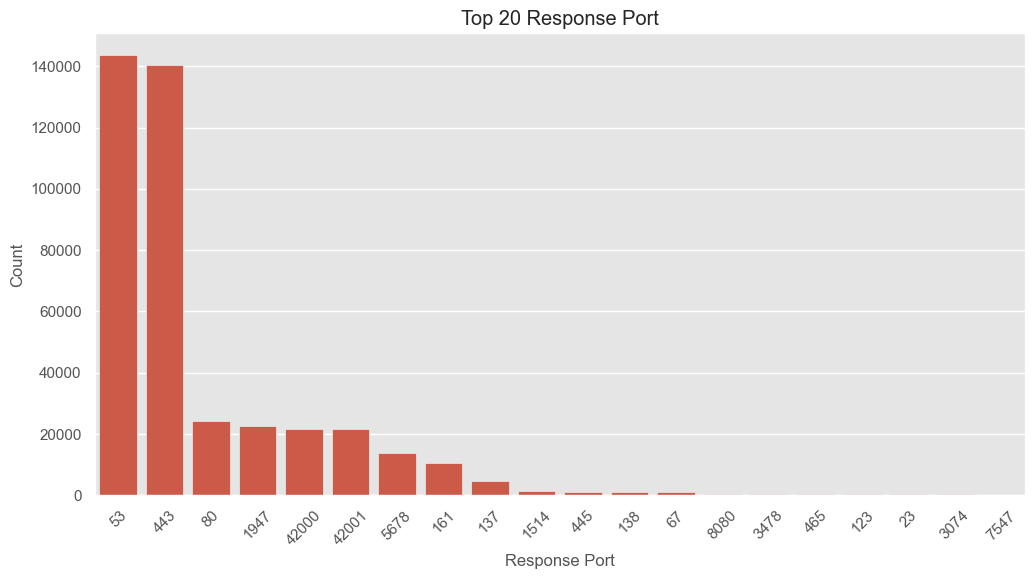

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='response_port', order=train['response_port'].value_counts().iloc[:20].index)
plt.title('Top 20 Response Port')
plt.xlabel('Response Port')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

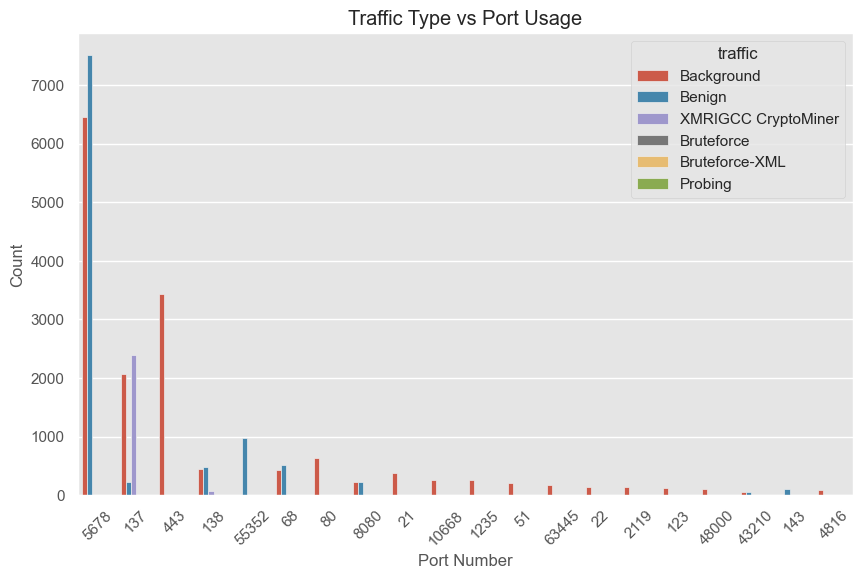

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='origin_port', hue='traffic', order=train['origin_port'].value_counts().iloc[:20].index)
plt.title('Traffic Type vs Port Usage')
plt.xlabel('Port Number')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

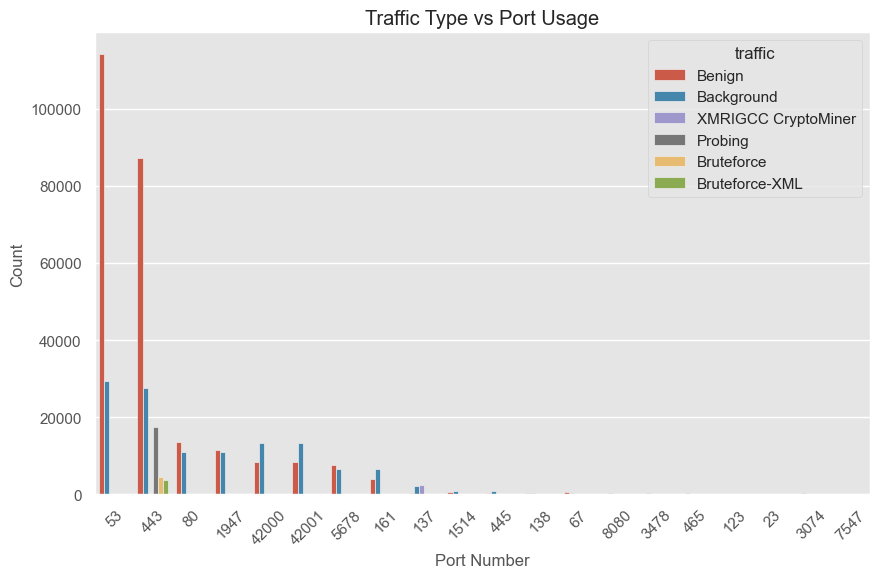

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='response_port', hue='traffic', order=train['response_port'].value_counts().iloc[:20].index)
plt.title('Traffic Type vs Port Usage')
plt.xlabel('Port Number')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

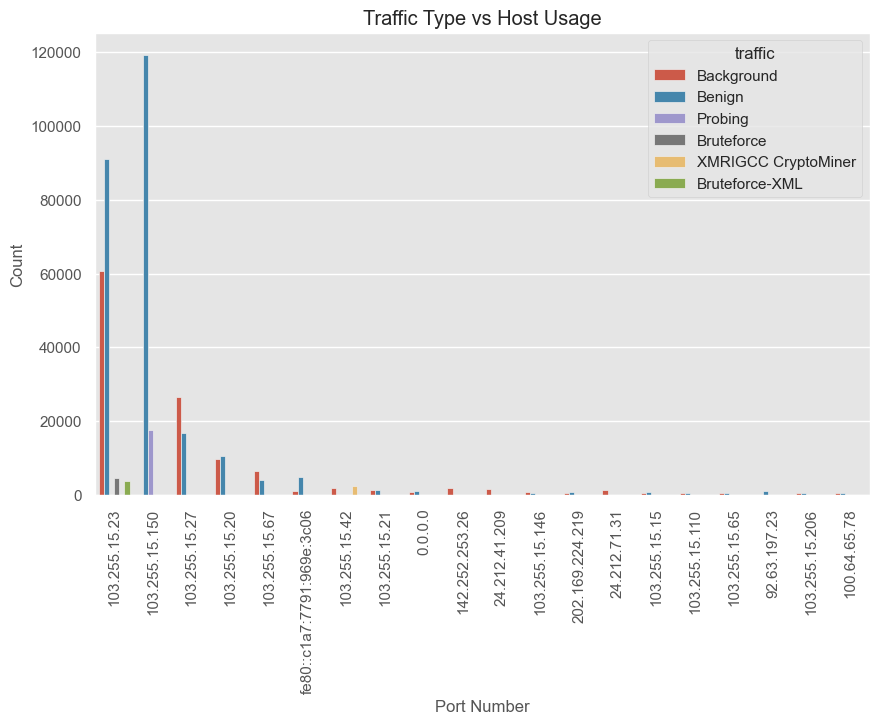

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='origin_host', hue='traffic', order=train['origin_host'].value_counts().iloc[:20].index)
plt.title('Traffic Type vs Host Usage')
plt.xlabel('Port Number')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

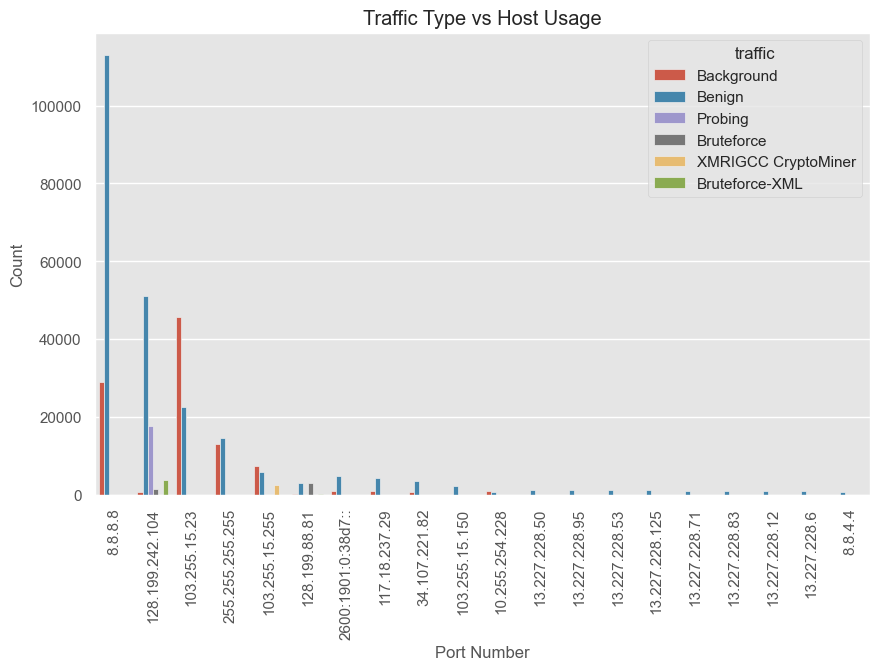

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='response_host', hue='traffic', order=train['response_host'].value_counts().iloc[:20].index)
plt.title('Traffic Type vs Host Usage')
plt.xlabel('Port Number')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

In [23]:
bening_data = train[train['traffic'] == 'Benign']
background_data = train[train['traffic'] == 'Background']
probing_data = train[train['traffic'] == 'Probing']
bruteforce_data = train[train['traffic'] == 'Bruteforce']
bruteforce_xml_data = train[train['traffic'] == 'Bruteforce-XML']
cryptominer_data = train[train['traffic'] == 'XMRIGCC CryptoMiner']

In [24]:
bening_data.describe()

,origin_port,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size
count,260576.000000,260576.000000,170952.000000,162109.000000,212369.000000,197406.000000,162730.000000,190500.000000,219702.000000,179852.000000,195848.000000,231924.000000,189330.000000,182906.0,218690.0,168180.000000,221230.000000,171333.000000,170392.000000,199693.000000,2.152290e+05,1.942040e+05,1.990180e+05,2.156680e+05,186698.000000,199667.000000,212433.000000,1.878250e+05,173896.000000,1.694150e+05,169584.000000,233426.000000,1.789250e+05,1.802200e+05,2.194100e+05,2.123490e+05,188305.000000,183949.000000,204181.000000
mean,40422.597526,3371.980463,8.223493,1188.248928,1121.854620,2319.761270,0.904054,0.543916,0.840079,0.435441,7.375296,10.970676,33.097137,0.0,0.0,0.000095,0.000018,54.009623,312.903293,189.142664,1.035516e+06,2.959853e+05,9.219438e+05,3.103240e+04,12.828323,13.543405,1573.181815,1.723618e+04,14.276585,6.768408e+03,0.017192,2.559247,3.613303e+02,6.653761e+06,6.600651e+05,3.996210e+06,13343.622910,21317.904441,3044.721086
std,16529.465544,10592.040600,102.999879,4823.652586,4103.121742,8600.733604,0.374385,0.795757,0.948408,0.715059,78.298642,99.118799,267.049090,0.0,0.0,0.012433,0.004252,47.273068,575.622056,290.426604,6.767844e+06,1.619832e+06,6.700431e+06,2.123772e+05,83.118203,88.049772,17889.917699,1.415029e+05,942.917572,7.278528e+04,0.475344,16.982464,2.420131e+04,1.995334e+07,1.279604e+07,1.997605e+07,14654.500958,29770.661787,8959.787927
min,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,33586.000000,53.000000,0.024287,10.906044,7.440469,18.448067,0.933333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,36.000000,52.000000,50.800000,0.000000e+00,0.000000e+00,8.141994e+03,5.888202e+02,1.000000,1.000000,40.000000,5.200000e+01,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.418995e+04,0.000000e+00,0.000000,0.000000,0.000000
50%,43672.000000,161.000000,0.026013,40.330622,44.962923,83.706629,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,40.000000,95.000000,68.000000,2.002716e+01,8.471012e+02,1.063982e+04,8.119838e+03,2.000000,2.000000,72.000000,1.470000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.584505e+04,0.000000e+00,0.000000,0.000000,0.000000
75%,53392.000000,443.000000,0.288134,79.449614,79.358668,158.818001,1.000000,1.000000,2.000000,1.000000,3.000000,5.000000,20.000000,0.0,0.0,0.000000,0.000000,83.500000,462.777778,274.571429,3.231912e+04,2.133759e+04,2.480102e+04,1.713897e+04,9.000000,9.000000,807.500000,4.112000e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.704573e+05,0.000000e+00,29200.000000,65160.000000,402.000000
max,65535.000000,65512.000000,15615.860670,182361.043478,88768.338624,182361.043478,6.000000,15.000000,7.000000,12.000000,3953.000000,18868.000000,42395.000000,0.0,0.0,3.000000,1.000000,3718.933934,19194.344828,10265.046192,6.000000e+07,5.796491e+07,6.000000e+07,2.208799e+07,5934.000000,6577.000000,345

In [25]:
background_data.describe()

,origin_port,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size
count,127616.000000,127616.000000,110661.000000,108344.000000,93483.000000,86919.000000,107058.000000,93242.000000,86075.000000,111403.000000,80198.000000,98756.000000,78660.000000,106362.000000,81319.000000,89831.000000,98977.000000,88858.000000,86409.000000,112460.000000,1.093780e+05,9.148200e+04,9.844300e+04,8.781900e+04,90268.000000,107613.000000,103042.000000,8.754500e+04,94386.000000,1.035770e+05,77037.000000,109355.000000,7.694800e+04,9.180500e+04,1.005820e+05,8.798200e+04,106128.000000,102608.000000,79655.000000
mean,35762.969800,9668.140280,12.839088,3203.145538,3148.071763,6375.128376,0.808034,0.438365,0.892965,0.462474,2.010574,5.486664,25.466946,0.004654,0.000025,0.007124,0.000071,40.897572,233.004273,137.552720,1.715938e+06,4.906355e+05,1.609942e+06,4.553305e+04,6.456705,6.051000,233.433854,1.034232e+04,37.241678,4.988277e+03,0.062465,1.827567,2.833874e+03,1.572866e+05,6.384935e+05,4.837558e+06,14979.388418,12572.568815,8579.016697
std,20192.304721,16895.095428,117.974320,5647.177443,5396.361014,11002.313795,0.714480,0.843907,1.127411,1.130503,18.580176,166.451984,515.929838,0.068337,0.004959,0.101280,0.009536,60.273269,559.028669,271.343233,8.848519e+06,1.977544e+06,8.752819e+06,2.628615e+05,76.260578,80.032439,974.737843,2.083094e+05,1205.342141,4.031323e+04,0.779722,17.788321,1.231217e+05,2.912301e+06,2.982381e+06,1.949489e+07,15670.752997,23057.142688,14510.069389
min,21.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,17687.750000,80.000000,0.000083,0.417187,0.190231,0.799009,0.631579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,8.296967e+01,0.000000e+00,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,7.605553e+01,0.000000e+00,0.000000,0.000000,0.000000
50%,40468.000000,443.000000,0.023800,49.265653,43.763606,96.877889,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,36.000000,31.000000,52.500000,0.000000e+00,0.000000e+00,6.953256e+03,6.647747e+01,1.000000,1.000000,51.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.156449e+03,0.000000e+00,5840.000000,0.000000,0.000000
75%,52860.000000,5678.000000,0.624143,6887.198686,6808.935065,13706.875817,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.785714,159.000000,122.000000,2.470601e+04,1.670754e+04,4.516854e+04,9.137871e+03,2.000000,2.000000,139.000000,3.180000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.815039e+05,0.000000e+00,29200.000000,26544.000000,28800.000000
max,65534.000000,65522.000000,17393.030600,223696.213333,83886.080000,167772.160000,6.000000,10.000000,23.000000,101.000000,3911.000000,48653.000000,118234.000000,2.000000,1.000000,4.000000,2.000000,3169.613636,8830.662222,4488.037037,1.010646e+

In [26]:
probing_data.describe()

,origin_port,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size
count,17543.000000,17543.0,12416.000000,14188.000000,10873.000000,12638.000000,15460.000000,12436.000000,13137.000000,13403.000000,15775.000000,13436.000000,12469.000000,15165.0,14017.0,10997.0,11176.0,13772.000000,13311.000000,12162.000000,1.493700e+04,1.310000e+04,1.166400e+04,11621.000000,15190.000000,11948.000000,14543.000000,14229.000000,14214.0,10675.000000,12328.0,14310.000000,14503.0,1.480800e+04,1.538700e+04,1.143300e+04,14738.0,14112.0,12590.000000
mean,46939.958730,443.0,2.664172,34.343432,44.404287,78.844169,1.296955,1.093358,2.000076,1.098485,43.308399,49.497767,109.434598,0.0,0.0,0.0,0.0,100.893727,586.890385,376.574290,4.568982e+04,3.815879e+04,2.111386e+04,29891.219234,49.722273,56.967665,10357.270050,25427.950816,0.0,3783.284871,0.0,4.037945,0.0,3.754611e+07,2.178968e+06,2.183335e+05,29200.0,65160.0,351.434392
std,8242.779335,0.0,10.227754,8.320749,10.724159,18.679588,0.119299,0.291773,0.008725,0.301466,193.245976,200.255672,403.277408,0.0,0.0,0.0,0.0,41.527805,121.164111,62.224477,1.870559e+05,2.305789e+05,1.084497e+05,8661.088663,193.690594,200.898729,46406.756307,91848.444372,0.0,2123.252734,0.0,2.090723,0.0,3.447228e+07,8.655224e+06,2.593904e+06,0.0,0.0,120.143381
min,32768.000000,443.0,0.127633,0.132865,0.250065,0.552004,0.777778,0.000000,2.000000,0.000000,3.000000,2.000000,15.000000,0.0,0.0,0.0,0.0,58.142857,207.888525,214.463617,1.468767e+04,8.665820e+03,6.008593e+03,63.275087,5.000000,4.000000,420.500000,1734.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,1.109968e+05,0.000000e+00,29200.0,65160.0,0.000000
25%,39758.000000,443.0,0.244561,30.266002,38.749935,69.623205,1.300000,1.000000,2.000000,1.000000,3.000000,7.000000,20.000000,0.0,0.0,0.0,0.0,83.900000,591.500000,379.708333,2.881700e+04,1.884429e+04,1.171791e+04,25141.828489,9.000000,12.000000,835.000000,8281.000000,0.0,4585.000000,0.0,5.000000,0.0,4.309925e+06,2.442875e+05,0.000000e+00,29200.0,65160.0,402.000000
50%,46944.000000,443.0,0.270747,35.141265,45.717513,81.103831,1.300000,1.000000,2.000000,1.000000,3.000000,7.000000,22.000000,0.0,0.0,0.0,0.0,85.444444,637.000000,396.478261,3.188199e+04,2.110217e+04,1.290729e+04,32608.763561,10.000000,13.000000,838.000000,8281.000000,0.0,4585.000000,0.0,5.000000,0.0,3.924670e+07,2.707438e+05,0.000000e+00,29200.0,65160.0,402.000000
75%,54326.000000,443.0,0.311646,38.799081,50.645918,89.199879,1.333333,1.000000,2.000000,1.000000,3.000000,7.000000,22.000000,0.0,0.0,0.0,0.0,93.333333,637.000000,414.727273,3.683167e+04,2.533677e+04,1.504465e+04,35371.107591,10.000000,13.000000,842.000000,8281.000000,0.0,4585.000000,0.0,5.000000,0.0,6.284603e+07,3.111230e+05,0.000000e+00,29200.0,65160.0,402.000000
max,60996.000000,443.0,138.095687,75.649240,93.328481,165.372455,1.972656,2.000000,3.000000,3.000000,1413.000000,1414.000000,3876.000000,0.0,0.0,0.0,0.0,241.592044,1155.642857,629.370370,3.913915e+06,4.978880e+06,3.877250e+06,66453.341645,1434.000000,2576.000000,340249.000000,690280.000000,0.0,12483.000000,0.0,9.000000,0.0,1.764301e+08,1.345458e+08,6.361711e+07,29200.0,65160.0,1424.000000


In [27]:
bruteforce_data.describe()

,origin_port,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size
count,4414.000000,4414.0,1228.000000,3947.000000,2875.000000,3044.000000,2976.000000,3918.000000,2262.000000,1395.000000,3586.000000,3657.000000,3328.000000,2667.0,3161.0,3292.0,2679.0,3082.000000,2843.000000,3919.000000,2833.000000,2818.000000,3778.000000,3318.000000,3970.000000,3633.000000,2678.000000,3205.000000,2845.0,3154.000000,3381.0,2972.000000,3049.0,3.654000e+03,2.800000e+03,2.793000e+03,3760.000000,3711.000000,3074.000000
mean,32669.444495,443.0,4.557906,17.562376,17.346795,34.542029,0.867190,2.040582,2.007073,2.329749,9.530954,17.868745,91.483173,0.0,0.0,0.0,0.0,56.043489,1412.798596,685.715593,169621.621286,233615.054748,95806.188460,29336.407778,40.716830,38.989696,1373.660505,74354.994618,0.0,40287.648963,0.0,14.097871,0.0,4.470404e+05,2.450865e+06,1.800648e+06,29184.615957,40833.521962,0.889070
std,18624.865434,0.0,2.568980,15.514645,16.148145,31.615680,0.159226,0.225141,0.098388,0.499868,3.954521,10.634712,82.581765,0.0,0.0,0.0,0.0,26.288588,812.931364,392.013247,145374.765532,222651.208133,85149.775762,40114.248433,43.767494,43.421751,553.548409,129842.192145,0.0,75732.309143,0.0,24.652087,0.0,1.844671e+06,1.965640e+06,2.409757e+06,666.947499,17012.567717,14.386026
min,1037.000000,443.0,0.805569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,271.666667,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,268.000000,0.000000,0.000000
25%,16683.250000,443.0,1.792772,3.329442,2.334632,5.695282,0.695652,2.000000,2.000000,2.000000,6.000000,9.000000,35.000000,0.0,0.0,0.0,0.0,36.018519,954.615385,467.955939,32125.587049,30203.917781,15607.865612,2652.445688,10.500000,7.500000,820.000000,7158.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,1.051308e+06,0.000000e+00,29200.000000,28960.000000,0.000000
50%,32328.500000,443.0,4.140728,10.818263,9.759372,19.722991,0.882353,2.000000,2.000000,2.000000,8.000000,13.000000,71.500000,0.0,0.0,0.0,0.0,58.292857,1048.100000,536.782178,93634.336423,102881.399301,49453.670120,22256.712577,20.000000,17.500000,1545.500000,40123.000000,0.0,17699.250000,0.0,7.500000,0.0,1.876481e+05,1.712303e+06,0.000000e+00,29200.000000,28960.000000,0.000000
75%,48944.500000,443.0,6.648165,31.679217,33.076791,64.614513,1.000000,2.000000,2.000000,3.000000,14.000000,29.000000,99.000000,0.0,0.0,0.0,0.0,78.714286,1406.800000,658.970903,315505.266190,458787.821806,180494.999454,35051.672371,51.000000,52.000000,1811.000000,52405.000000,0.0,34074.000000,0.0,12.500000,0.0,4.918835e+05,3.273703e+06,5.002746e+06,29200.000000,65160.000000,0.000000
max,65514.000000,443.0,14.506962,79.545904,82.707704,145.715416,1.244444,3.000000,3.000000,5.000000,33.000000,41.000000,450.000000,0.0,0.0,0.0,0.0,134.277778,5723.666667,2765.808642,542868.614197,796750.593185,306838.781937,258951.506318,229.000000,215.000000,3482.000000,482446.000000,0.0,403866.000000,0.0,174.000000,0.0,7.598084e+07,1.290647e+07,1.050589e+07,29200.000000,65160.000000,356.000000


In [28]:
bruteforce_xml_data.describe()

,origin_port,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size
count,3860.000000,3860.0,2497.000000,2689.000000,2909.000000,2627.000000,2974.000000,2523.000000,2431.000000,2946.000000,3012.000000,3096.000000,3460.000000,2939.0,2827.0,2433.0,3013.0,1599.000000,2291.000000,2689.000000,3.124000e+03,2.699000e+03,2.791000e+03,2996.000000,2415.000000,3154.000000,1799.000000,2784.000000,2778.0,3157.0,3209.0,2587.0,2438.0,2716.0,2.510000e+03,3.128000e+03,3351.0,2726.000000,2736.0
mean,11765.913212,443.0,9.988334,2.273750,2.076681,4.378632,0.938764,1.996829,2.006582,1.992872,5.994688,4.936693,24.521098,0.0,0.0,0.0,0.0,129.111009,377.962762,249.425642,7.502277e+05,8.074233e+05,3.741031e+05,1087.383823,7.085300,6.658159,914.090699,2509.430855,0.0,0.0,0.0,0.0,0.0,0.0,1.032218e+06,8.789220e+06,29200.0,65120.161409,0.0
std,10046.006525,0.0,5.928059,2.349582,1.632443,4.681599,0.029686,0.056232,0.080877,0.095484,0.106131,0.252670,0.904753,0.0,0.0,0.0,0.0,3.734843,17.862752,8.664854,4.129353e+05,4.774431e+05,2.206104e+05,1240.572041,0.305474,0.400589,36.879146,96.212742,0.0,0.0,0.0,0.0,0.0,0.0,1.591661e+06,6.785558e+06,0.0,1200.457639,0.0
min,1090.000000,443.0,0.216705,0.301318,0.109991,0.228442,0.785714,1.000000,2.000000,1.000000,4.000000,3.000000,21.000000,0.0,0.0,0.0,0.0,108.000000,335.000000,221.225806,1.775415e+04,1.566752e+04,8.626223e+03,147.430559,5.000000,4.000000,451.500000,1667.000000,0.0,0.0,0.0,0.0,0.0,0.0,9.961450e+04,0.000000e+00,29200.0,28960.000000,0.0
25%,6336.500000,443.0,4.692836,1.033567,0.959963,1.989221,0.928571,2.000000,2.000000,2.000000,6.000000,5.000000,24.000000,0.0,0.0,0.0,0.0,130.571429,358.928571,244.857143,3.621024e+05,3.880293e+05,1.799888e+05,502.187347,7.000000,6.500000,915.000000,2512.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.121225e+05,0.000000e+00,29200.0,65160.000000,0.0
50%,10737.000000,443.0,9.269208,1.539603,1.427226,2.955438,0.928571,2.000000,2.000000,2.000000,6.000000,5.000000,24.000000,0.0,0.0,0.0,0.0,130.785714,386.538462,253.888889,7.032755e+05,7.581482e+05,3.503640e+05,739.371349,7.000000,6.500000,915.500000,2512.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.161472e+05,8.904386e+06,29200.0,65160.000000,0.0
75%,14570.500000,443.0,13.683553,3.004047,2.782733,5.790679,0.933333,2.000000,2.000000,2.000000,6.000000,5.000000,25.000000,0.0,0.0,0.0,0.0,130.857143,386.538462,253.962963,1.044083e+06,1.125960e+06,5.210082e+05,1410.319106,7.000000,7.000000,916.000000,2512.500000,0.0,0.0,0.0,0.0,0.0,0.0,2.187418e+06,1.338400e+07,29200.0,65160.000000,0.0
max,65524.000000,443.0,118.191717,60.115722,6.855889,121.336631,1.000000,2.000000,3.000000,4.000000,7.000000,7.000000,28.000000,0.0,0.0,0.0,0.0,141.076923,662.400000,376.350000,3.574045e+06,9.846992e+06,4.545836e+06,31277.531102,14.000000,14.000000,1830.000000,4948.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.064711e+06,1.179662e+08,29200.0,65160.000000,0.0


In [29]:
cryptominer_data.describe()

,origin_port,response_port,flow_duration,forward_packets_per_sec,backward_packets_per_sec,flow_packets_per_sec,down_up_ratio,flow_FIN_flags,flow_SYN_flags,flow_RST_flags,forward_PSH_flags,backward_PSH_flags,flow_ACK_flags,forward_URG_flags,backward_URG_flags,flow_CWR_flags,flow_ECE_flags,forward_pkts_payload,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,flow_iat,payload_bytes_per_sec,forward_subflow_packets,backward_subflow_packets,forward_subflow_bytes,backward_subflow_bytes,forward_bulk_bytes,backward_bulk_bytes,forward_bulk_packets,backward_bulk_packets,forward_bulk_rate,backward_bulk_rate,active,idle,forward_initial_window_size,backward_initial_window_size,forward_last_window_size
count,2464.000000,2464.000000,1655.000000,1804.000000,1725.0,2089.000000,1660.0,1805.0,1856.0,2038.0,1529.0,2050.0,1695.0,2134.0,1911.0,2081.0,2096.0,1548.000000,1565.0,2209.000000,1947.000000,1906.0,2208.000000,1963.000000,1914.000000,1503.0,1980.000000,1835.0,1257.0,958.0,1736.0,1542.0,2146.0,1493.0,1.520000e+03,1031.0,1561.0,1616.0,1700.0
mean,137.025974,137.025974,1.484278,1.909264,0.0,1.913716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.487080,0.0,53.964690,745461.855721,0.0,744567.190553,95.529132,2.946708,0.0,151.339394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.488386e+06,0.0,0.0,0.0,0.0
std,0.159090,0.159090,0.256602,0.319117,0.0,0.305838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.648395,0.0,24.149812,118549.192962,0.0,121233.430277,15.762355,0.322176,0.0,8.157740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.447713e+05,0.0,0.0,0.0,0.0
min,137.000000,137.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,0.0,50.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,150.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
25%,137.000000,137.000000,1.528557,1.962507,0.0,1.962507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,0.0,50.000000,764277.517795,0.0,764278.054237,98.125029,3.000000,0.0,150.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.528555e+06,0.0,0.0,0.0,0.0
50%,137.000000,137.000000,1.528607,1.962566,0.0,1.962566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,0.0,50.000000,764303.088188,0.0,764303.922653,98.128304,3.000000,0.0,150.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.528606e+06,0.0,0.0,0.0,0.0
75%,137.000000,137.000000,1.528652,1.962628,0.0,1.962628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,0.0,50.000000,764326.930046,0.0,764325.976372,98.131503,3.000000,0.0,150.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.528652e+06,0.0,0.0,0.0,0.0
max,138.000000,138.000000,1.532379,1.997042,0.0,1.997042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.000000,0.0,201.000000,772934.913635,0.0,772934.913635,99.852082,3.000000,0.0,201.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.545870e+06,0.0,0.0,0.0,0.0


In [30]:
for i in train.columns:
    print(i)
    print(bening_data[i].value_counts())
    print()

origin_host
origin_host
103.255.15.150               119340
103.255.15.23                 91198
103.255.15.27                 16717
103.255.15.20                 10419
fe80::c1a7:7791:969e:3c06      4831
                              ...  
192.241.206.146                   1
212.71.252.153                    1
8.140.117.105                     1
47.111.115.42                     1
192.241.206.147                   1
Name: count, Length: 1262, dtype: int64

origin_port
origin_port
5678     7512
55352     968
68        513
138       485
8080      232
         ... 
23974       1
31495       1
23985       1
1728        1
39751       1
Name: count, Length: 56335, dtype: int64

response_host
response_host
8.8.8.8            113178
128.199.242.104     51156
103.255.15.23       22503
255.255.255.255     14449
103.255.15.255       5892
                    ...  
212.224.118.36          1
151.236.98.170          1
184.25.122.49           1
13.32.54.123            1
104.17.115.176          1
Name:

In [31]:
for i in train.columns:
    print(i)
    print(background_data[i].value_counts())
    print()

origin_host
origin_host
103.255.15.23      60588
103.255.15.27      26595
103.255.15.20       9770
103.255.15.67       6524
103.255.15.42       1921
                   ...  
117.50.99.165          1
128.199.101.113        1
125.76.246.24          1
103.107.85.126         1
36.155.117.24          1
Name: count, Length: 1449, dtype: int64

origin_port
origin_port
5678     6457
443      3442
137      2066
80        636
138       449
         ... 
23441       1
18703       1
65523       1
40769       1
14605       1
Name: count, Length: 46695, dtype: int64

response_host
response_host
103.255.15.23      45654
8.8.8.8            28964
255.255.255.255    12929
103.255.15.255      7383
10.255.254.228       876
                   ...  
54.230.151.102         1
13.35.0.110            1
74.125.130.136         1
202.241.208.56         1
54.212.14.254          1
Name: count, Length: 4453, dtype: int64

response_port
response_port
53       29473
443      27608
42001    13307
42000    13288
80      

In [32]:
for i in train.columns:
    print(i)
    print(probing_data[i].value_counts())
    print()

origin_host
origin_host
103.255.15.150    17543
Name: count, dtype: int64

origin_port
origin_port
59040    2
38848    2
60258    2
46922    2
48360    2
        ..
51056    1
48282    1
49234    1
44970    1
59746    1
Name: count, Length: 12095, dtype: int64

response_host
response_host
128.199.242.104    17543
Name: count, dtype: int64

response_port
response_port
443    17543
Name: count, dtype: int64

flow_duration
flow_duration
0.253319    3
0.282022    3
0.232052    3
0.270336    3
0.270101    3
           ..
0.270293    1
0.269707    1
0.224324    1
0.287406    1
0.235711    1
Name: count, Length: 11909, dtype: int64

forward_packets_per_sec
forward_packets_per_sec
44.538664    3
37.999112    3
36.743632    2
33.086892    2
32.365482    2
            ..
37.852987    1
35.877304    1
36.911390    1
36.179036    1
28.153470    1
Name: count, Length: 13981, dtype: int64

backward_packets_per_sec
backward_packets_per_sec
49.398846    3
56.380766    2
50.470730    2
48.665462    2
4

In [33]:
for i in train.columns:
    print(i)
    print(bruteforce_data[i].value_counts())
    print()

origin_host
origin_host
103.255.15.23    4414
Name: count, dtype: int64

origin_port
origin_port
57495    3
10522    3
27541    3
58921    2
6385     2
        ..
55550    1
21349    1
7156     1
62286    1
9814     1
Name: count, Length: 4291, dtype: int64

response_host
response_host
128.199.88.81      2972
128.199.242.104    1442
Name: count, dtype: int64

response_port
response_port
443    4414
Name: count, dtype: int64

flow_duration
flow_duration
1.478820    2
6.314259    1
1.487247    1
2.166444    1
4.726512    1
           ..
6.916346    1
1.517404    1
1.594886    1
1.479245    1
6.005685    1
Name: count, Length: 1227, dtype: int64

forward_packets_per_sec
forward_packets_per_sec
0.000000     2
4.274596     1
3.351944     1
30.821350    1
32.576283    1
            ..
38.696795    1
34.562993    1
30.589884    1
30.735993    1
3.163669     1
Name: count, Length: 3946, dtype: int64

backward_packets_per_sec
backward_packets_per_sec
2.003156     2
1.724663     2
35.342600    1

In [34]:
for i in train.columns:
    print(i)
    print(bruteforce_xml_data[i].value_counts())
    print()

origin_host
origin_host
103.255.15.23    3860
Name: count, dtype: int64

origin_port
origin_port
15834    2
15720    2
15840    2
14072    2
14658    2
        ..
14546    1
13210    1
15398    1
16008    1
5192     1
Name: count, Length: 3649, dtype: int64

response_host
response_host
128.199.242.104    3857
128.199.88.81         3
Name: count, dtype: int64

response_port
response_port
443    3860
Name: count, dtype: int64

flow_duration
flow_duration
15.759303    2
6.852637     2
11.323313    2
15.624266    1
13.819438    1
            ..
6.683655     1
15.535225    1
4.382506     1
11.644267    1
13.903275    1
Name: count, Length: 2494, dtype: int64

forward_packets_per_sec
forward_packets_per_sec
5.792879    2
1.011545    2
6.390885    2
1.032341    2
6.393427    2
           ..
0.887912    1
0.887521    1
1.497266    1
1.589886    1
1.006957    1
Name: count, Length: 2683, dtype: int64

backward_packets_per_sec
backward_packets_per_sec
1.148074    2
0.939292    2
3.162631    2
2.

In [35]:
for i in train.columns:
    print(i)
    print(cryptominer_data[i].value_counts())
    print()

origin_host
origin_host
103.255.15.42    2464
Name: count, dtype: int64

origin_port
origin_port
137    2400
138      64
Name: count, dtype: int64

response_host
response_host
103.255.15.255    2464
Name: count, dtype: int64

response_port
response_port
137    2400
138      64
Name: count, dtype: int64

flow_duration
flow_duration
0.000000    48
1.528622    15
1.528616    15
1.528643    14
1.528608    13
            ..
1.528306     1
1.527953     1
1.528227     1
1.528694     1
1.528833     1
Name: count, Length: 391, dtype: int64

forward_packets_per_sec
forward_packets_per_sec
0.000000    49
1.962566    17
1.962513    16
1.962585    16
1.962525    15
            ..
1.962736     1
1.961329     1
1.962757     1
1.963059     1
1.962281     1
Name: count, Length: 449, dtype: int64

backward_packets_per_sec
backward_packets_per_sec
0.0    1725
Name: count, dtype: int64

flow_packets_per_sec
flow_packets_per_sec
0.000000    52
1.962560    20
1.962579    18
1.962566    18
1.962516    16
   

# **Data Preperation**

### **Feature Imputation**

In [36]:
class FeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fill_flow_packets_per_sec(self, row):
        forward_packets, backward_packets, flow_packets = row
        if pd.isna(flow_packets):
            if pd.isna(forward_packets):
                return backward_packets * 2
            elif pd.isna(backward_packets):
                return forward_packets * 2
            else:
                return forward_packets + backward_packets
        return flow_packets

    def fill_forward_packets_per_sec(self, row):
        forward_packets, backward_packets, flow_packets = row
        if pd.isna(forward_packets):
            if pd.isna(backward_packets):
                return flow_packets / 2
            elif pd.isna(flow_packets):
                return backward_packets
            else:
                return flow_packets - backward_packets
        return forward_packets

    def fill_backward_packets_per_sec(self, row):
        forward_packets, backward_packets, flow_packets = row
        if pd.isna(backward_packets):
            if pd.isna(forward_packets):
                return flow_packets / 2
            elif pd.isna(flow_packets):
                return forward_packets
            else:
                return flow_packets - forward_packets
        return backward_packets

    def fill_pkts(self, row):
        forward_payload, backward_payload, flow_payload = row
        if pd.isna(forward_payload):
            return flow_payload * 2 - backward_payload, backward_payload, flow_payload
        elif pd.isna(backward_payload):
            return forward_payload, flow_payload * 2 - forward_payload, flow_payload
        elif pd.isna(flow_payload):
            return forward_payload, backward_payload, (forward_payload + backward_payload) / 2
        return forward_payload, backward_payload, flow_payload

    def fill_iat(self, row):
        forward_iat, backward_iat, flow_iat = row
        if pd.isna(forward_iat):
            return flow_iat * 4 - backward_iat, backward_iat, flow_iat
        elif pd.isna(backward_iat):
            return forward_iat, flow_iat * 4 - forward_iat, flow_iat
        elif pd.isna(flow_iat):
            return forward_iat, backward_iat, (forward_iat + backward_iat) / 4
        return forward_iat, backward_iat, flow_iat

    def fill_subflow_packets(self, row, formula='mul'):
        forward_subflow, backward_subflow, down_up_ratio = row
        if pd.isna(forward_subflow):  # Jika forward_subflow hilang
            if not pd.isna(backward_subflow) and not pd.isna(down_up_ratio):
                if formula == 'mul':
                    return backward_subflow * down_up_ratio
                elif formula == 'div':
                    if down_up_ratio <= 0.01:
                        return 0
                    return backward_subflow / down_up_ratio
            return np.nan
        return forward_subflow

    def fill_flow_duration(self, row):
        flow_duration, active_time, idle_time = row
        if pd.isna(flow_duration):
            return active_time + idle_time, active_time, idle_time
        elif pd.isna(active_time):
            return flow_duration, flow_duration - idle_time, idle_time
        elif pd.isna(idle_time):
            return flow_duration, active_time, flow_duration - active_time
        return flow_duration, active_time, idle_time

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        # Imputasi untuk packets per sec
        df['forward_packets_per_sec'] = df[['forward_packets_per_sec', 'backward_packets_per_sec', 'flow_packets_per_sec']].apply(self.fill_forward_packets_per_sec, axis=1)
        df['backward_packets_per_sec'] = df[['forward_packets_per_sec', 'backward_packets_per_sec', 'flow_packets_per_sec']].apply(self.fill_backward_packets_per_sec, axis=1)
        df['flow_packets_per_sec'] = df[['forward_packets_per_sec', 'backward_packets_per_sec', 'flow_packets_per_sec']].apply(self.fill_flow_packets_per_sec, axis=1)

        # Imputasi untuk payload packets
        df[['forward_pkts_payload', 'backward_pkts_payload', 'flow_pkts_payload']] = df[
            ['forward_pkts_payload', 'backward_pkts_payload', 'flow_pkts_payload']].apply(
            self.fill_pkts, axis=1, result_type='expand')

        # Imputasi untuk IAT
        df[['forward_iat', 'backward_iat', 'flow_iat']] = df[['forward_iat', 'backward_iat', 'flow_iat']].apply(
            self.fill_iat, axis=1, result_type='expand')

        # Imputasi untuk subflow packets
        df['forward_subflow_packets'] = df[['forward_subflow_packets', 'backward_subflow_packets', 'down_up_ratio']].apply(self.fill_subflow_packets, axis=1)
        df['forward_subflow_packets'] = df[['backward_subflow_packets', 'forward_subflow_packets', 'down_up_ratio']].apply(self.fill_subflow_packets, axis=1)
        df['down_up_ratio'] = df[['down_up_ratio', 'forward_subflow_packets', 'backward_subflow_packets']].apply(self.fill_subflow_packets, axis=1, formula='div')

        # Konversi dari active dan idle menjadi detik
        df['active'] = df['active'] / 1_000_000
        df['idle'] = df['idle'] / 1_000_000

        # Imputasi untuk flow_duration
        df[['flow_duration', 'active', 'idle']] = df[['flow_duration', 'active', 'idle']].apply(
            self.fill_flow_duration, axis=1, result_type='expand')

        df['active'] = np.maximum(df['active'], 0)
        df['idle'] = np.maximum(df['idle'], 0)

        return df


### **Feature Dropping**

In [37]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=None):
        # Fitur yang akan di-drop
        if features_to_drop is None:
            self.features_to_drop = [
                'backward_bulk_bytes', 
                'forward_last_window_size', 
                'forward_bulk_rate', 
                'forward_PSH_flags', 
                'backward_initial_window_size', 
                'forward_pkts_payload', 
                'forward_bulk_bytes', 
                'down_up_ratio', 
                'backward_subflow_packets', 
                'flow_iat', 
                'flow_ACK_flags', 
                'forward_initial_window_size', 
                'flow_SYN_flags', 
                'backward_subflow_bytes', 
                'active', 
                'flow_duration', 
                'backward_packets_per_sec', 
                'flow_packets_per_sec', 
                'flow_ECE_flags',
                'flow_CWR_flags',
                'forward_URG_flags',
                'backward_URG_flags'
            ]
        else:
            self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        # Tidak perlu melakukan apa-apa pada fit
        return self

    def transform(self, X):
        # Drop kolom yang telah ditentukan
        df = X.copy()
        df = df.drop(self.features_to_drop, axis=1)
        return df


### **Label Changer**

In [38]:
class LabelChanger(BaseEstimator, TransformerMixin):
    def __init__(self, to_numeric=True):
        # Mode pengubahan label (to_numeric untuk mengubah ke numerik, False untuk mengubah kembali ke label asli)
        self.to_numeric = to_numeric
        self.label_mapping = {
            'Benign': 0,
            'Background': 1,
            'Probing': 2,
            'Bruteforce': 3,
            'Bruteforce-XML': 4,
            'XMRIGCC CryptoMiner': 5
        }
        self.reverse_label_mapping = {v: k for k, v in self.label_mapping.items()}

    def fit(self, X, y=None):
        # Tidak perlu melakukan apa-apa pada fit
        return self

    def transform(self, X):
        df = X.copy()
        if self.to_numeric:
            # Mengubah label ke numerik
            df[LABEL] = df[LABEL].map(self.label_mapping)
        else:
            # Mengubah label kembali ke bentuk string aslinya
            df[LABEL] = df[LABEL].map(self.reverse_label_mapping)
        return df


### **Feature Engineering**

In [39]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Tidak ada parameter yang perlu diset pada awalnya
        pass

    def fit(self, X, y=None):
        # Tidak perlu melakukan apa-apa pada fit
        return self

    def transform(self, X):
        df = X.copy()

        # Konversi kolom object ke kategori
        cat_cols = df.select_dtypes(include='object').columns
        for col in cat_cols:
            df[col] = df[col].astype('category')

        # Konversi kolom-kolom port dan host_port menjadi kategori
        df['origin_port'] = df['origin_port'].astype('category')
        df['response_port'] = df['response_port'].astype('category')        
        return df


### **Feature Creation**

In [40]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, train_data):
        # Simpan data train untuk keperluan frequency encoding
        self.train_data = train_data
        self.origin_freq_encoding = None
        self.response_freq_encoding = None

    def fit(self, X, y=None):
        # Membuat kamus frequency encoding berdasarkan data train
        self.origin_freq_encoding = self.train_data['origin_host'].value_counts().to_dict()
        self.response_freq_encoding = self.train_data['response_host'].value_counts().to_dict()
        return self

    def transform(self, X):
        df = X.copy()

        # 1. Create binary feature for high PSH flags
        df['is_PSH'] = (df['forward_PSH_flags'] + df['backward_PSH_flags'] > 150).astype(int)

        # 2. Combine host and port into a new feature
        df['origin_host_origin_port'] = df['origin_host'].astype(str) + ':' + df['origin_port'].astype(str)
        df['response_host_response_port'] = df['response_host'].astype(str) + ':' + df['response_port'].astype(str)
        df['origin_host_response_port'] = df['origin_host'].astype(str) + ':' + df['response_port'].astype(str)
        df['response_host_origin_response_port'] = df['response_host'].astype(str) + ':' + df['origin_port'].astype(str) + ':' + df['response_port'].astype(str)

        # 3. Host to Port Ratio (using length of host string as a proxy for uniqueness)
        df['host_to_port_ratio'] = df['origin_host'].apply(len) / df['origin_port']

        # 4. Frequency encoding for origin and response hosts
        df['origin_host_freq'] = df['origin_host'].map(lambda x: self.origin_freq_encoding.get(x, 0))
        df['response_host_freq'] = df['response_host'].map(lambda x: self.response_freq_encoding.get(x, 0))
        
        # 5. Port Service Type
        def port_service_type(port):
            if port in [80, 8080]:
                return 'HTTP'
            elif port == 443:
                return 'HTTPS'
            elif port == 21:
                return 'FTP'
            elif port == 22:
                return 'SSH'
            else:
                return 'Other'

        df['origin_port_service_type'] = df['origin_port'].apply(port_service_type)
        df['response_port_service_type'] = df['response_port'].apply(port_service_type)
        
        return df


### **One Hot Encoder**

In [41]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Define the columns to be one-hot encoded inside the class
        self.columns = ['origin_port_service_type', 'response_port_service_type'] 

    def fit(self, X, y=None):
        return self  # No fitting needed for one-hot encoding

    def transform(self, X):
        df = X.copy()
        # Perform one-hot encoding on the specified columns
        df = pd.get_dummies(df, columns=self.columns)
        return df


# **Pipeline**

In [42]:
# Buat pipeline dengan berbagai step
pipeline = Pipeline([
    ('feature_imputation', FeatureImputer()),  # Mengisi nilai yang hilang
    ('feature_creation', FeatureCreator(train_data=train)),  # Membuat fitur baru
    ('feature_dropper', FeatureDropper()),  # Menghapus fitur yang tidak digunakan
    ('feature_engineering', FeatureEngineer()),  # Mengubah tipe data kolom menjadi category
    ('OneHotEncoder', OneHotEncoder()),  # One-hot encoding
], verbose=True)

# Jalankan pipeline pada data train dan test
train_pipe = pipeline.fit_transform(train)
test_pipe = pipeline.transform(test)

[Pipeline]  (step 1 of 5) Processing feature_imputation, total=  26.2s
[Pipeline] .. (step 2 of 5) Processing feature_creation, total=   1.1s
[Pipeline] ... (step 3 of 5) Processing feature_dropper, total=   0.2s
[Pipeline]  (step 4 of 5) Processing feature_engineering, total=   0.7s
[Pipeline] ..... (step 5 of 5) Processing OneHotEncoder, total=   0.1s


In [43]:
train_pipe.head()

,origin_host,origin_port,response_host,response_port,forward_packets_per_sec,flow_FIN_flags,flow_RST_flags,backward_PSH_flags,backward_pkts_payload,flow_pkts_payload,forward_iat,backward_iat,payload_bytes_per_sec,forward_subflow_packets,forward_subflow_bytes,forward_bulk_packets,backward_bulk_packets,backward_bulk_rate,idle,traffic,is_PSH,origin_host_origin_port,response_host_response_port,origin_host_response_port,response_host_origin_response_port,host_to_port_ratio,origin_host_freq,response_host_freq,origin_port_service_type_FTP,origin_port_service_type_HTTP,origin_port_service_type_HTTPS,origin_port_service_type_Other,origin_port_service_type_SSH,response_port_service_type_FTP,response_port_service_type_HTTP,response_port_service_type_HTTPS,response_port_service_type_Other,response_port_service_type_SSH
0,103.255.15.27,45314,103.255.15.23,42001,11125.474801,0.0,NaN,NaN,0.000000,0.000000,0.000000e+00,3.595352e+02,0.000000,1.000000,0.000000,0.0,0.0,0.0,1.161960e-07,Background,0,103.255.15.27:45314,103.255.15.23:42001,103.255.15.27:42001,103.255.15.23:45314:42001,0.000287,43312,68157,False,False,False,True,False,False,False,False,True,False
1,103.255.15.27,45060,103.255.15.23,42000,30174.848921,NaN,NaN,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000e+00,Background,0,103.255.15.27:45060,103.255.15.23:42000,103.255.15.27:42000,103.255.15.23:45060:42000,0.000289,43312,68157,False,False,False,True,False,False,False,False,True,False
2,103.255.15.23,3440,52.45.16.192,443,0.322699,2.0,0.0,6.0,408.733333,215.628571,3.261959e+06,4.408952e+06,121.770606,2.142857,202.285714,NaN,0.0,0.0,9.861604e+00,Background,0,103.255.15.23:3440,52.45.16.192:443,103.255.15.23:443,52.45.16.192:3440:443,0.003779,160060,3,False,False,False,True,False,False,False,True,False,False
3,103.255.15.150,56132,8.8.8.8,53,82.478177,0.0,0.0,0.0,73.500000,54.750000,1.192093e+01,3.231986e+04,9031.360437,2.000000,72.000000,NaN,0.0,0.0,1.615750e-07,Benign,0,103.255.15.150:56132,8.8.8.8:53,103.255.15.150:53,8.8.8.8:56132:53,0.000249,136883,142142,False,False,False,True,False,False,False,False,True,False
4,103.255.15.150,43358,8.8.8.8,53,36.258128,NaN,0.0,0.0,95.000000,65.500000,0.000000e+00,0.000000e+00,4749.814781,1.000000,36.000000,0.0,0.0,0.0,0.000000e+00,Benign,0,103.255.15.150:43358,8.8.8.8:53,103.255.15.150:53,8.8.8.8:43358:53,0.000323,136883,142142,False,False,False,True,False,False,False,False,True,False


In [44]:
# Split data menjadi data latih dan data uji
X = train_pipe.drop(columns=LABEL)

# Mengubah label menjadi numerik
pipeline_label = LabelChanger()
y = pipeline_label.fit_transform(train_pipe)[LABEL]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# **Modelling**

In [45]:
# Define Scoring Function
def scoring(y_true: List[int], y_pred: List[int]) -> float:
    return (accuracy_score(y_true, y_pred) + balanced_accuracy_score(y_true, y_pred)) / 2

In [46]:
# Define the unique classes
classes = np.unique(y)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)

# Convert to list
class_weights_list = list(class_weights)
print(class_weights_list)

[0.2663797382209669, 0.5439142949682381, 3.9566873776815066, 15.725456879625435, 17.982426597582037, 28.170522186147185]


In [47]:
# CatBoost
cat_features = ['origin_host', 'response_host', 'origin_port', 'response_port', 'origin_host_origin_port', 'response_host_response_port', 'origin_host_response_port', 'response_host_origin_response_port']
model = CatBoostClassifier(silent=True, random_state=42, task_type='GPU', cat_features=cat_features, class_weights=class_weights_list)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)

# Scoring
score = scoring(y_val, y_pred)
print(f"Score: {score}")
print(f"Balanaced Accuracy: {balanced_accuracy_score(y_val, y_pred)}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Score: 0.8618503452872197
Balanaced Accuracy: 0.9295713910966796
Accuracy: 0.7941292994777598
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     52085
           1       0.73      0.90      0.81     25660
           2       0.39      0.98      0.56      3471
           3       0.72      0.99      0.83       849
           4       0.66      0.99      0.79       744
           5       0.57      1.00      0.72       486

    accuracy                           0.79     83295
   macro avg       0.67      0.93      0.76     83295
weighted avg       0.85      0.79      0.80     83295

[[37664  8456  5271   318   376     0]
 [ 2241 23033     0    15     0   371]
 [   85     0  3386     0     0     0]
 [    8     0     0   841     0     0]
 [    6     0     0     1   737     0]
 [    0     0     0     0     0   486]]


In [48]:
# XGBoost
model = XGBClassifier(random_state=42, verbose=0, enable_categorical=True, use_label_encoder=True)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)

# Scoring
score = scoring(y_val, y_pred)
print(f"Score: {score}")
print(f"Balanaced Accuracy: {balanced_accuracy_score(y_val, y_pred)}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Score: 0.7311555970486849
Balanaced Accuracy: 0.660102177949942
Accuracy: 0.8022090161474278
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     52085
           1       0.78      0.76      0.77     25660
           2       0.41      0.21      0.28      3471
           3       0.75      0.75      0.75       849
           4       0.69      0.67      0.68       744
           5       0.73      0.70      0.72       486

    accuracy                           0.80     83295
   macro avg       0.70      0.66      0.67     83295
weighted avg       0.79      0.80      0.80     83295

[[45060  5505  1077   216   227     0]
 [ 5987 19548     0     2     0   123]
 [ 2736     0   735     0     0     0]
 [  212     0     0   637     0     0]
 [  244     0     0     0   500     0]
 [    0   146     0     0     0   340]]


In [49]:
# LightGBM
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(enumerate(class_weights))

model = LGBMClassifier(random_state=42, class_weight=class_weights, verbose=-100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)

# Scoring
score = scoring(y_val, y_pred)
print(f"Score: {score}")
print(f"Balanaced Accuracy: {balanced_accuracy_score(y_val, y_pred)}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Score: 0.8273332415470533
Balanaced Accuracy: 0.8975382040857628
Accuracy: 0.7571282790083438
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     52085
           1       0.72      0.89      0.79     25660
           2       0.32      0.91      0.47      3471
           3       0.57      0.96      0.72       849
           4       0.52      0.97      0.68       744
           5       0.58      0.99      0.73       486

    accuracy                           0.76     83295
   macro avg       0.61      0.90      0.70     83295
weighted avg       0.83      0.76      0.77     83295

[[35026  9109  6683   598   669     0]
 [ 2430 22880     0     5     0   345]
 [  327     0  3144     0     0     0]
 [   38     0     0   811     0     0]
 [   18     0     0     1   725     0]
 [    0     7     0     0     0   479]]


# **Save Model and Data**

In [50]:
# Train the model
cat_features = ['origin_host', 'response_host', 'origin_port', 'response_port', 'origin_host_origin_port', 'response_host_response_port', 'origin_host_response_port', 'response_host_origin_response_port']
model = CatBoostClassifier(silent=True, random_state=42, task_type='GPU', cat_features=cat_features, class_weights=class_weights_list)
model.fit(X, y)

In [ ]:
# Save the model to pickle file
import pickle

with open('model_catboost.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
# Save data train and test
train_pipe.to_csv('train_after_pipeline.csv', index=False)
test_pipe.to_csv('test_after_pipeline.csv', index=False)

# **Lampiran**

In [ ]:
# # CatBoost
# cat_features = ['origin_host', 'response_host', 'origin_port', 'response_port', 'origin_host_origin_port', 'response_host_response_port', 'origin_host_response_port', 'response_host_origin_response_port']
# model = CatBoostClassifier(silent=True, random_state=42, task_type='GPU', cat_features=cat_features, class_weights=class_weights_list)
# model.fit(X_train, y_train)

# # Predict
# y_preds_proba = model.predict_proba(test_pipe)

# threshold = np.array([0.4, 0.35, 0.757, 0.35, 0.35, 0.35])

# # Apply thresholds to determine final predictions
# final_preds = np.argmax(y_preds_proba >= threshold, axis=1)
# final_preds = final_preds.flatten()

# # Scoring
# score = scoring(y_val, y_pred)
# print(f"Score: {score}")
# print(f"Balanaced Accuracy: {balanced_accuracy_score(y_val, y_pred)}")
# print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
# print(classification_report(y_val, y_pred))
# print(confusion_matrix(y_val, y_pred))

In [ ]:
# import optuna
# from catboost import CatBoostClassifier
# import numpy as np
# from sklearn.metrics import balanced_accuracy_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the objective function for Optuna
# def objective(trial):
#     # Hyperparameter search space for CatBoost
#     params = {
#         'iterations': trial.suggest_int('iterations', 1000, 2000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'task_type': 'GPU',  # GPU acceleration
#         'silent': True,
#         'random_state': 42
#     }
    
#     # Define threshold 
#     thresholds = np.array([0.4, 0.6, 0.757, 0.35, 0.35, 0.35])

#     categorical_features = ['origin_host', 'response_host', 'origin_port', 'response_port', 'origin_host_origin_port', 'response_host_response_port', 'origin_host_response_port', 'response_host_origin_response_port']

#     # Train CatBoost model
#     model = CatBoostClassifier(
#         cat_features=categorical_features,
#         class_weights=class_weights_list,
#         **params
#     )
    
#     model.fit(X_train, y_train)
    
#     # Predict probabilities for the test set
#     y_pred_proba = model.predict_proba(X_test)
    
#     # Apply thresholds to convert probabilities into class labels
#     y_pred = np.argmax(y_pred_proba >= np.array(thresholds), axis=1)
#     y_pred = y_pred.flatten()
    
#     # Calculate balanced accuracy
#     bal_acc = scoring(y_test, y_pred)
    
#     return bal_acc

# # Initialize the study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Print the best trial
# print(f'Best trial: {study.best_trial.params}')


In [ ]:
# def backward_feature_elimination(X, y, categorical_features, label_num, class_weights_dict):
#     selected_features = list(X.columns)
#     best_bal_acc = 0  # Starting with the worst possible balanced accuracy (0)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     while len(selected_features) > len(categorical_features):  # Ensure categorical features remain
#         worst_feature = None
        
#         for feature in selected_features:
#             if feature in categorical_features:
#                 continue  # Skip categorical features
            
#             current_features = selected_features.copy()
#             current_features.remove(feature)
            
#             model = CatBoostClassifier(silent=True, random_state=42, task_type='GPU', 
#                                        cat_features=categorical_features, 
#                                        class_weights=class_weights_dict)
            
#             model.fit(X_train[current_features], y_train)
            
#             y_pred = model.predict_proba(X_test[current_features])

#             threshold = np.array([0.4, 0.6, 0.757, 0.35, 0.35, 0.35])

#             # Apply thresholds to determine final predictions
#             y_pred = np.argmax(y_pred >= threshold, axis=1)
            
#             y_pred = y_pred.flatten()

#             bal_acc = scoring(y_test, y_pred)
            
#             if bal_acc > best_bal_acc:
#                 best_bal_acc = bal_acc
#                 worst_feature = feature
            
#             print(f"Feature: {feature}, Balanced Accuracy: {bal_acc:.6f}")
        
#         if worst_feature is not None:
#             selected_features.remove(worst_feature)
#             print(f"Removed {worst_feature}, Best Balanced Accuracy: {best_bal_acc:.6f}")
#         else:
#             break
    
#     return selected_features

# # Define categorical features and label_num before running the function
# categorical_features = ['origin_host', 'response_host', 'origin_port', 'response_port', 'origin_host_origin_port', 'response_host_response_port', 'origin_host_response_port', 'response_host_origin_response_port']

# selected_features = backward_feature_elimination(X, y, categorical_features, label_num, class_weights_list)
# print(selected_features)
